## Human Detection for WatchPoint devices

#### Introduction

The _WatchPoint_ company aims to provide state of the art security camera system: dedicated to keep every customer safe. This investigation is presented to follow the company's goal of bringing mayor innovation to their products. Conventional security cameras utilize motion detection in order to alert of possible break-ins; however, many factors can trigger this security measures and lead to false alarms. Not only is it inconvinient to the customer, but to the enterprise as well. To solve this issue, a deep learning model is proposed to diminish the amount of false positives. The cameras will load an image every so often and on movement detection to the company's server. It will then analyze the picture using a CNN model and alert if a human is detected or not.

#### Image Analysis

Loading and viewing of the image dataset to train the model. This dataset was obtained through kaggle and consists of 921 images.

These will be separated with a validation split of 0.2 and in batch size of 32. This was done to give a better training set to the models. The images are cropped to fit 480 x 480

In [8]:
# Load required libraries
import numpy as np
import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers
from keras.utils import image_dataset_from_directory, array_to_img
import keras.optimizers as optim
import keras.losses as loss
import keras.metrics as mtrc
import matplotlib.pyplot as plt

In [9]:
image = (480, 480) # Image size
image_size = (480, 480, 3) # Image size & color
batch = 32 # Batch size 
split = 0.2 # Percentage of validation
crop = True # Crop images or pad

In [10]:
dirImages = "/kaggle/input/human-detection-dataset/human detection dataset" # Directory

train = image_dataset_from_directory(
    dirImages,
    labels="inferred",
    label_mode="int",
    class_names=None,
    batch_size=batch,
    image_size=image,
    shuffle=True,
    seed=333,
    validation_split=split,
    subset="training",
    interpolation="nearest",
    follow_links=False,
    crop_to_aspect_ratio=crop,
    pad_to_aspect_ratio=(not crop),
    data_format=None,
    verbose=True,
)

test = image_dataset_from_directory(
    dirImages,
    labels="inferred",
    label_mode="int",
    class_names=None,
    batch_size=batch,
    image_size=image,
    shuffle=True,
    seed=333,
    validation_split=split,
    subset="validation",
    interpolation="nearest",
    follow_links=False,
    crop_to_aspect_ratio=crop,
    pad_to_aspect_ratio=(not crop),
    data_format=None,
    verbose=True,
)

Found 921 files belonging to 2 classes.
Using 737 files for training.
Found 921 files belonging to 2 classes.
Using 184 files for validation.


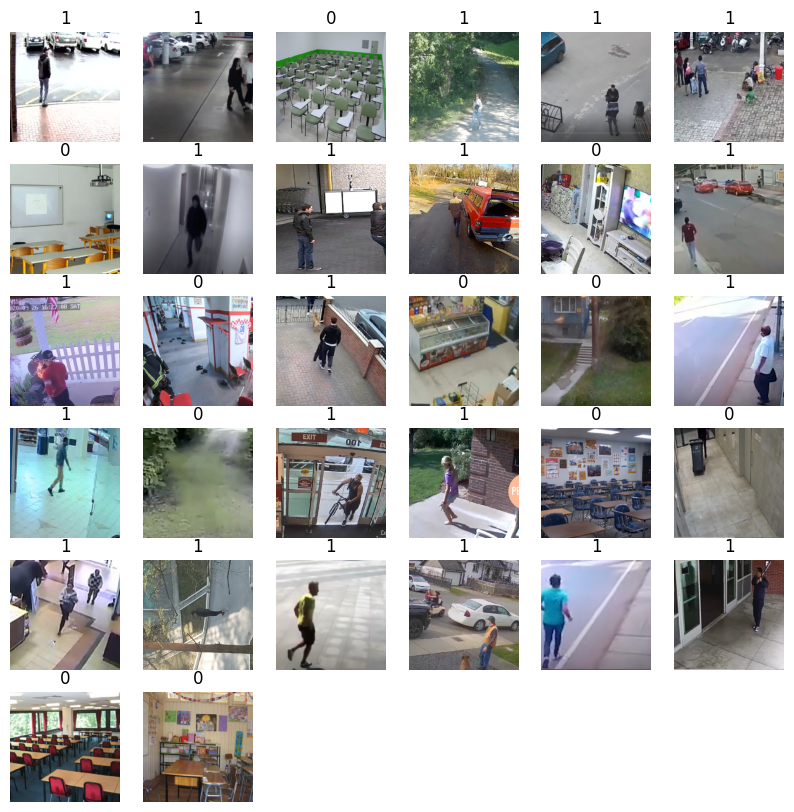

In [11]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train.take(1).unbatch()):
    ax = plt.subplot(6, 6, i + 1)
    image = array_to_img(image)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

#### Data Augmentation

The images are then passed through data augmentation in order to expand the dataset and prevent overfitting

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomZoom(0.2)
])

#### CNN model

Here a CNN model is implemented. It has 5 layers for which

In [13]:
model = keras.Sequential([
    
    # Input images and data augmentation
    keras.Input(shape=image_size),
    data_augmentation,

    # First layer of convolution, normalization and pooling
    layers.Conv2D(filters=32,kernel_size=5,activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Second layer of convolution, normalization and pooling
    layers.Conv2D(filters=64,kernel_size=5,activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Third layer of convolution, normalization and pooling
    layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Fourth layer of convolution, normalization and pooling
    layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Fifth layer of convolution, normalization and pooling
    layers.Conv2D(filters=512, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Average pooling for flattening
    layers.GlobalAveragePooling2D(),

    # Fully connected NN layer
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.25), 
    layers.Dense(1, activation="softmax")
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 480, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 476, 476, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 476, 476, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 234, 234, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 234, 234, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 117, 117, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 115, 115, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 115, 115, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 57, 57, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 55, 55, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 55, 55, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 25, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,672,641 (6.38 MB)

 Trainable params: 1,670,657 (6.37 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
model.compile(
    optimizer=optim.Adam(),
    loss=loss.BinaryCrossentropy(from_logits=False),
    metrics=[mtrc.BinaryAccuracy(), mtrc.Precision(), mtrc.Recall()],
)

model.fit(train, epochs=3)

Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 533s 22s/step - binary_accuracy: 0.5791 - loss: 1.0043 - precision_1: 0.5791 - recall_1: 1.0000
Epoch 2/3
20/24 ━━━━━━━━━━━━━━━━━━━━ 1:31 23s/step - binary_accuracy: 0.5909 - loss: 0.7780 - precision_1: 0.5909 - recall_1: 1.0000

In [ ]:
model.evaluate(test) # Test the model

## Pre-trained CNN model

In [ ]:
# Load a convolutional base with pre-trained weights
base_model = keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=image_size,
    pooling='avg'
)

# Freeze the base model
base_model.trainable = False

# Transfer learning model
model = keras.Sequential([
    keras.Input(shape=image_size),
    layers.Rescaling(scale=1 / 127.5, offset=-1),
    base_model,
    #layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

model.summary(show_trainable=True)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.fit(train, epochs=3)

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=optim.Adam(),
    loss=loss.BinaryCrossentropy(from_logits=False),
    metrics=[mtrc.BinaryAccuracy(), mtrc.Precision(), mtrc.Recall()],
)

model.fit(train, epochs=3)

In [ ]:
model.evaluate(test)

#### Visual Prediction

Show model

In [ ]:
testBatch = test.take(1)
predBatch = model.predict(testBatch)

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(testBatch.unbatch()):
    ax = plt.subplot(6, 6, i + 1)
    image = array_to_img(image)
    plt.imshow(image)
    if predBatch[i][0] > 0.5:
        plt.title("Human")
    else:
        plt.title("No Human")
    plt.axis("off")